In [1]:
'''Итак, наша цель - спрогнозировать LTV на горизонте 90 дней, чтобы в дальнейшем оценить, приносит ли выгоду покупка 
трафика через Facebook Ads для выдуманной f2p игры на iOS. Перед нами датасет с транзакциями пользователей, которые 
устанавливали игру с 18 сентября по 1 октября 2023 года (на промежутке 14 дней). Датасет содержит их идентификатор, 
время регистрации в игре и осуществления платежа (если они были), основные каналы привлечения, страну юзера, а также размер платежа'''

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta, date
import matplotlib.pyplot as plt
df = pd.read_csv('14 days.csv', sep=';').sort_values(by=['created'])
df

,id,created,pay_date,ads,country,priceusd
0,9369894,2023-09-18 00:00:05.538,NaN,Unity Ads,AU,NaN
1,9369958,2023-09-18 00:00:18.647,NaN,Organic,RU,NaN
2,9369704,2023-09-18 00:00:41.349,2023-09-18 02:24:53.245,Organic,GB,1.0
3,9369704,2023-09-18 00:00:41.349,2023-09-18 02:24:45.696,Organic,GB,8.0
4,9369704,2023-09-18 00:00:41.349,2023-09-18 02:24:45.455,Organic,GB,2.5
...,...,...,...,...,...,...
43843,9413475,2023-10-01 23:57:30.007,NaN,Organic,RU,NaN
43844,9413481,2023-10-01 23:58:35.546,NaN,Organic,RU,NaN
43845,9412730,2023-10-01 23:58:49.129,NaN,Facebook Ads,RU,NaN
43846,9418712,2023-10-01 23:59:32.39,NaN,Organic,RU,NaN


In [2]:
'''Посчитаем, сколько человек зарегистрировалось в тот или иной день, какую в целом прибыль они принесли, 
исключая комиссию AppStore (30%)'''


def form(column: str) -> None:
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S.%f')
    df[column] = df[column].dt.date
    
    
form('created')
form('pay_date')

df = df[df['ads'] == 'Facebook Ads'].reset_index()
df['priceusd'] = df['priceusd'] * 0.7
df_gr = df.groupby('created').agg({'id': 'nunique', 'priceusd': 'sum'}).reset_index()
df_gr

,created,id,priceusd
0,2023-09-18,667,645.40
1,2023-09-19,437,569.45
2,2023-09-20,458,266.70
3,2023-09-21,567,546.00
4,2023-09-22,649,523.25
5,2023-09-23,555,421.75
6,2023-09-24,554,605.50
7,2023-09-25,444,290.85
8,2023-09-26,421,570.15
9,2023-09-27,586,740.60


In [3]:
'''Далее найдем прибыль для каждой когорты пользователей, которую они принесли в течение первых 14 дней своей жизни в игре. 
Заметим, что когорта 2023-09-30 принесла прибыль, которая значительно выше, чем у остальных.'''

df_cog = pd.DataFrame()
long_lt = len(df_gr['created'])


for j in range(long_lt):
    df_day = pd.DataFrame()
    for i in range(long_lt):
        df_loop = df[df['pay_date'].between(df_gr['created'][j] + timedelta(days=i), df_gr['created'][j] + timedelta(days=i+1))].reset_index(drop=True)
        df_loop = df_loop[df_loop['created'] == df_gr['created'][j]].groupby('created').sum()['priceusd'].reset_index()
        #df_day['Day ' + str(i+1)] = df_loop['priceusd'] * df_gr['share_vc'][j]
        df_day['Day ' + str(i+1)] = df_loop['priceusd']# - df_gr['vc'][0] / long_lt
    df_cog = pd.concat([df_cog, df_day])
    

df_cog.reset_index(drop=True, inplace=True)
df_present = df_cog.rename(index = {n: str(df_gr['created'][n]) for n in range(long_lt)})
df_present

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14
2023-09-18,300.65,88.20,44.80,117.60,113.75,57.75,54.25,80.15,53.20,52.15,58.80,22.05,10.85,3.50
2023-09-19,239.75,250.95,160.30,20.30,30.45,23.45,26.95,56.00,40.60,5.60,6.30,8.05,8.05,2.45
2023-09-20,143.85,46.20,44.10,7.35,1.75,3.50,1.75,NaN,5.60,5.60,0.70,0.70,NaN,8.40
2023-09-21,283.85,72.80,29.05,17.15,14.70,22.40,33.60,116.20,105.00,40.60,41.30,6.30,13.65,22.05
2023-09-22,319.55,159.95,18.55,77.35,80.85,20.65,60.55,43.40,NaN,10.15,15.75,8.05,3.15,0.70
2023-09-23,126.35,64.05,33.25,19.60,50.75,45.15,35.00,75.60,46.20,9.80,13.30,19.25,11.90,77.35
2023-09-24,329.35,112.70,1.75,42.70,86.80,82.60,77.35,43.05,37.45,36.75,7.35,5.60,36.75,42.35
2023-09-25,155.40,70.00,26.25,0.70,7.00,14.70,49.70,46.90,40.60,35.00,6.30,11.90,5.60,NaN
2023-09-26,270.20,109.90,45.15,36.75,155.75,122.50,2.45,0.70,NaN,5.60,42.35,36.75,NaN,NaN
2023-09-27,263.55,189.70,63.70,94.15,99.40,115.85,163.80,124.95,37.45,13.30,51.10,38.50,1.75,7.35


In [4]:
'''После того, как мы рассчитали прибыль, найдем среднюю взвешенную среди наших когорт для каждого дня, чтобы учесть 
количество установок, и произведем для них сложение нарастающим итогом. Таким образом, мы получим среднекогортный 
LTV за первые 14 дней с момента регистрации'''


def w_avg(values: float) -> float:
    return (df_gr['id'] * values).sum() / df_gr['id'].sum()


s_fact = df_cog.agg(w_avg).cumsum().reset_index(drop=True)
long_fact = len(s_fact)
df_trans = pd.DataFrame({'Day ' + str(n+1) : [round(s_fact[n], 2)] for n in range(long_fact)})
df_trans

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14
0,279.42,430.17,493.83,554.88,614.9,663.85,734.82,815.75,863.42,889.67,921.54,948.16,963.13,983.28


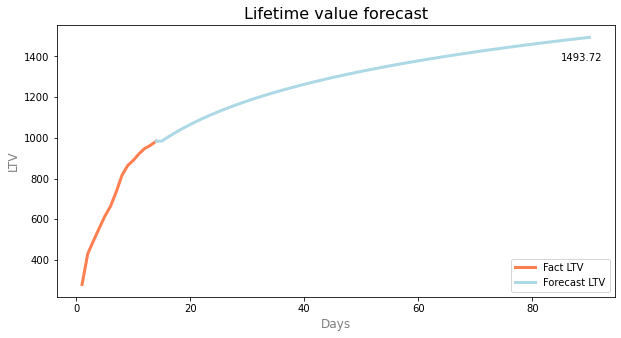

In [5]:
'''Для простого прогноза выведем функцию логарифмической регресии на основе данных за 2 недели
и визуализируем фактические и прогнозные значения на горизонте 90 дней. Таким образом, прогнозное значение LTV 90-го дня 
нашей средней когорты пользователей, привлеченных через Facebook Ads, составило $1493,72.'''

hrz = 90
frcst = np.polyfit(np.log(list(range(1, long_fact+1))), s_fact.values, 1)


def ln_func(x: int) -> float:
    return frcst[0] * np.log(x) + frcst[1]


s_frcst = pd.Series([ln_func(i) for i in range(long_fact+1,hrz+1)], range(long_fact+1,hrz+1), dtype='float')

plt.figure(figsize=(10,5))
plt.title('Lifetime value forecast', fontsize=16)
plt.xlabel('Days', color='grey', fontsize=12)
plt.ylabel('LTV', color='grey', fontsize=12)

x = list(range(1, long_fact+1))
y = s_fact.values
plt.plot(x, y, color='coral', linewidth=3)

x = list(range(long_fact, hrz+1))
y = [s_fact.values[-1], *s_frcst.values]
plt.plot(x, y, color='lightblue', linewidth=3)
plt.text(85, 1380, round(s_frcst.values[-1], 2))
plt.legend(['Fact LTV', 'Forecast LTV'], loc=4)
plt.show()